In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib

/Users/leejuan/Documents/GitHub/senior-road-risk-analyzer/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 데이터 로딩
df = pd.read_csv("../data/processed/accident_data_filtered.csv", low_memory=False)
df["is_elderly_accident"] = (df["acdnt_age_1_code"] < 65).astype(int)  # 65세 미만이면 1, 아니면 0
df = df[df["is_elderly_accident"] == 1]

In [3]:
print(df.shape)

(75855, 25)


In [4]:
# 사용 변수 정의
target_col = "non_elderly_hotspot"  # 종속변수 : 비고령자 사고다발 구역
feature_cols = [
    "occrrnc_time_code", #"acdnt_hdc", #"lrg_violt_1_dc",
    "road_stle_dc", #"wrngdo_vhcle_asort_dc",
    "rdse_sttus_dc", #"road_div",
    "near_crosswalk", "near_traffic_light", "near_child_zone",
    #"near_elderly_zone", "near_disabled_zone",
    "lanes", "lengths", "velocity", "traffic_volume"
]
# 한글 매핑 정의
feature_name_map = {
    "occrrnc_time_code": "사고 시간대",
    # "wrngdo_vhcle_asort_dc" : "사고 차량 종류",
    #"acdnt_hdc": "사고 유형",
    #"lrg_violt_1_dc": "법규 위반 유형",
    "road_stle_dc": "도로 구조",
    "rdse_sttus_dc": "도로 상태",
    #"road_div": "도로 등급",
    "near_crosswalk": "횡단보도 인근",
    "near_traffic_light": "신호등 인근",
    "near_child_zone": "어린이 보호구역 인근",
    #"near_elderly_zone": "노인 보호구역 인근",
    #"near_disabled_zone": "장애인 보호구역 인근",
    "lanes": "차선 수",
    "lengths": "도로 길이",
    "velocity": "속도",
    "traffic_volume": "교통량"
}
data = df[feature_cols + [target_col]].copy()

In [5]:
# 결측치 처리
data["lanes"] = data["lanes"].fillna(0)
data["lengths"] = data["lengths"].fillna(0)
data["velocity"] = data["velocity"].fillna(0)
#data["road_div"] = data["road_div"].fillna(data["road_div"].median())
data["traffic_volume"] = pd.to_numeric(data["traffic_volume"], errors="coerce")
data["traffic_volume"] = data["traffic_volume"].fillna(data["traffic_volume"].median())

In [6]:
# 범주형 변수 인코딩
cat_cols = data.select_dtypes(include="object").columns.tolist()
encoder = OrdinalEncoder()
data[cat_cols] = encoder.fit_transform(data[cat_cols])

# 매핑 확인
for col, cats in zip(cat_cols, encoder.categories_):
    print(f"\n🔸 '{col}' 컬럼 매핑")
    for i, category in enumerate(cats):
        print(f"  {i} → {category}")


🔸 'road_stle_dc' 컬럼 매핑
  0 → 교차로 - 교차로부근
  1 → 교차로 - 교차로안
  2 → 교차로 - 교차로횡단보도내
  3 → 기타 - 기타
  4 → 단일로 - 고가도로위
  5 → 단일로 - 교량
  6 → 단일로 - 기타
  7 → 단일로 - 지하차도(도로)내
  8 → 단일로 - 터널
  9 → 미분류 - 미분류
  10 → 주차장 - 주차장

🔸 'rdse_sttus_dc' 컬럼 매핑
  0 →  건조
  1 →  기타
  2 →  서리/결빙
  3 →  적설
  4 →  젖음/습기
  5 →  침수
  6 →  해빙


In [7]:
# X, y 분리
X = data.drop(columns=[target_col])
y = data[target_col]

In [ ]:
# 학습/테스트 분할
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train = X
y_train = y

In [9]:
print(y_train.isna().sum())  # NaN 개수 확인
# NaN 제거 (훈련 데이터에서)
train_idx = y_train.notna()
X_train = X_train[train_idx]
y_train = y_train[train_idx]

# X_train의 독립변수도 NaN 없도록 처리
X_train = X_train.dropna()

# 다시 한 번 인덱스 맞추기 (혹시 dropna로 어긋날 수 있으므로)
y_train = y_train.loc[X_train.index]

print(y_train.isna().sum())

0
0


In [10]:
# 모델 학습
model = xgb.XGBClassifier(eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [11]:
# SHAP 분석
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
#NaN 제거
valid_idx = y.notna() & X.notna().all(axis=1)  # y와 X 모두 결측값 없는 행만 선택

X_valid = X.loc[valid_idx]
y_valid = y.loc[valid_idx]


<Figure size 500x500 with 0 Axes>

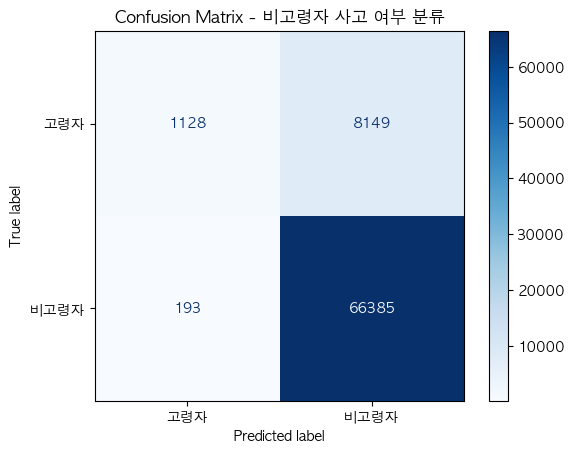

In [13]:
plt.rcParams['font.family'] = 'AppleGothic'  # macOS용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

y_pred = model.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["고령자", "비고령자"])
plt.figure(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - 비고령자 사고 여부 분류")
plt.grid(False)
plt.show()

In [14]:
# 평균 영향도 계산
shap_df = pd.DataFrame(shap_values, columns=X.columns)
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

# Top 10 영향 변수 정리
top_features = mean_abs_shap.head(10).reset_index()
top_features.columns = ["Feature", "Mean |SHAP Value|"]
top_features

,Feature,Mean |SHAP Value|
0,lanes,0.731975
1,traffic_volume,0.376547
2,lengths,0.370612
3,velocity,0.205965
4,road_stle_dc,0.194354
5,near_child_zone,0.130281
6,occrrnc_time_code,0.103479
7,near_crosswalk,0.046446
8,near_traffic_light,0.042934
9,rdse_sttus_dc,0.025659


In [15]:
print(X_valid.info())

<class 'pandas.core.frame.DataFrame'>
Index: 75855 entries, 0 to 95086
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   occrrnc_time_code   75855 non-null  int64  
 1   road_stle_dc        75855 non-null  float64
 2   rdse_sttus_dc       75855 non-null  float64
 3   near_crosswalk      75855 non-null  int64  
 4   near_traffic_light  75855 non-null  int64  
 5   near_child_zone     75855 non-null  int64  
 6   lanes               75855 non-null  float64
 7   lengths             75855 non-null  float64
 8   velocity            75855 non-null  float64
 9   traffic_volume      75855 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 6.4 MB
None


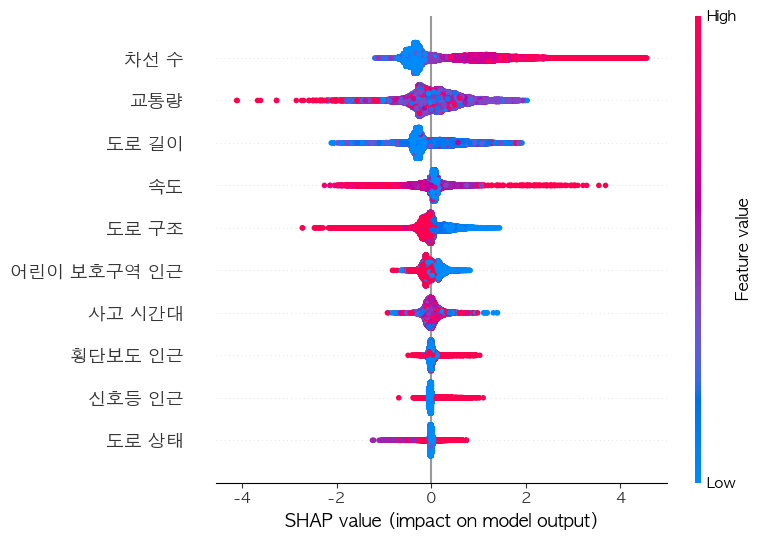

In [16]:
# 요약 시각화
X.columns = X.columns.map(lambda col: feature_name_map.get(col, col))
shap.summary_plot(shap_values, X)


**🔴 빨강 = 해당 특성 값이 높음<br>
🔵 파랑 = 해당 특성 값이 낮음**


100%|===================| 75851/75855 [01:47<00:00]        /Users/leejuan/Documents/GitHub/senior-road-risk-analyzer/venv/lib/python3.13/site-packages/shap/plots/_waterfall.py:635: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  text_bbox = txt_obj.get_window_extent(renderer=renderer)
/Users/leejuan/Documents/GitHub/senior-road-risk-analyzer/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


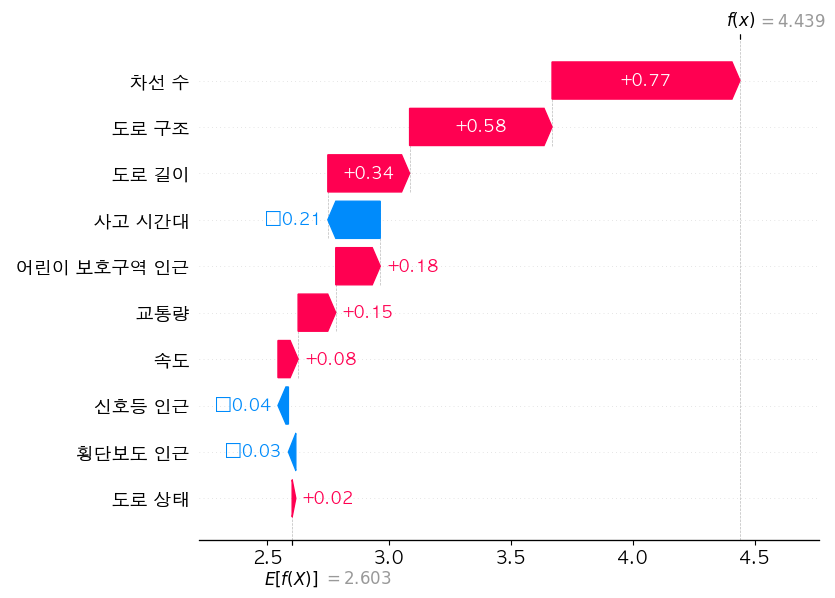

In [17]:
# TreeExplainer (딥러닝/토치 안 쓰도록 명시)
explainer = shap.TreeExplainer(model, X_train, model_output="raw")
shap_values = explainer.shap_values(X)

# 예: 0번째 샘플 기준
sample_idx = 0
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,  # 예측 기준선
    shap_values[sample_idx],  # 개별 샘플의 SHAP 값
    X.iloc[sample_idx]   # 입력 값 표시용
)

100%|===================| 75764/75855 [01:49<00:00]        

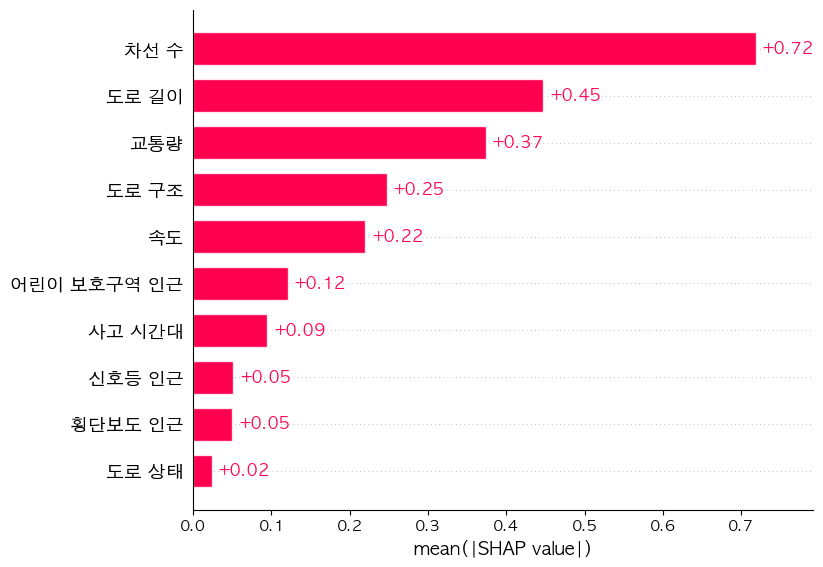

In [18]:
# TreeExplainer 사용
explainer = shap.TreeExplainer(model, X_train, model_output="raw")
shap_values = explainer.shap_values(X)

# SHAP 값이 다차원인 경우 (예: 이진분류 → 클래스별 SHAP)
if isinstance(shap_values, list):
    shap_vals = shap_values[1]  # 양성 클래스 기준으로
    base_val = explainer.expected_value[1]
else:
    shap_vals = shap_values
    base_val = explainer.expected_value

# 전체 데이터 요약 bar plot
shap.plots.bar(
    shap.Explanation(
        values=shap_vals,
        base_values=base_val,
        data=X,
        feature_names=X.columns
    )
)

1. 차선수
2. 도로 길이
3. 교통량
4. 도로 구조
5. 속도
6. 어린이 보호구역 인근 

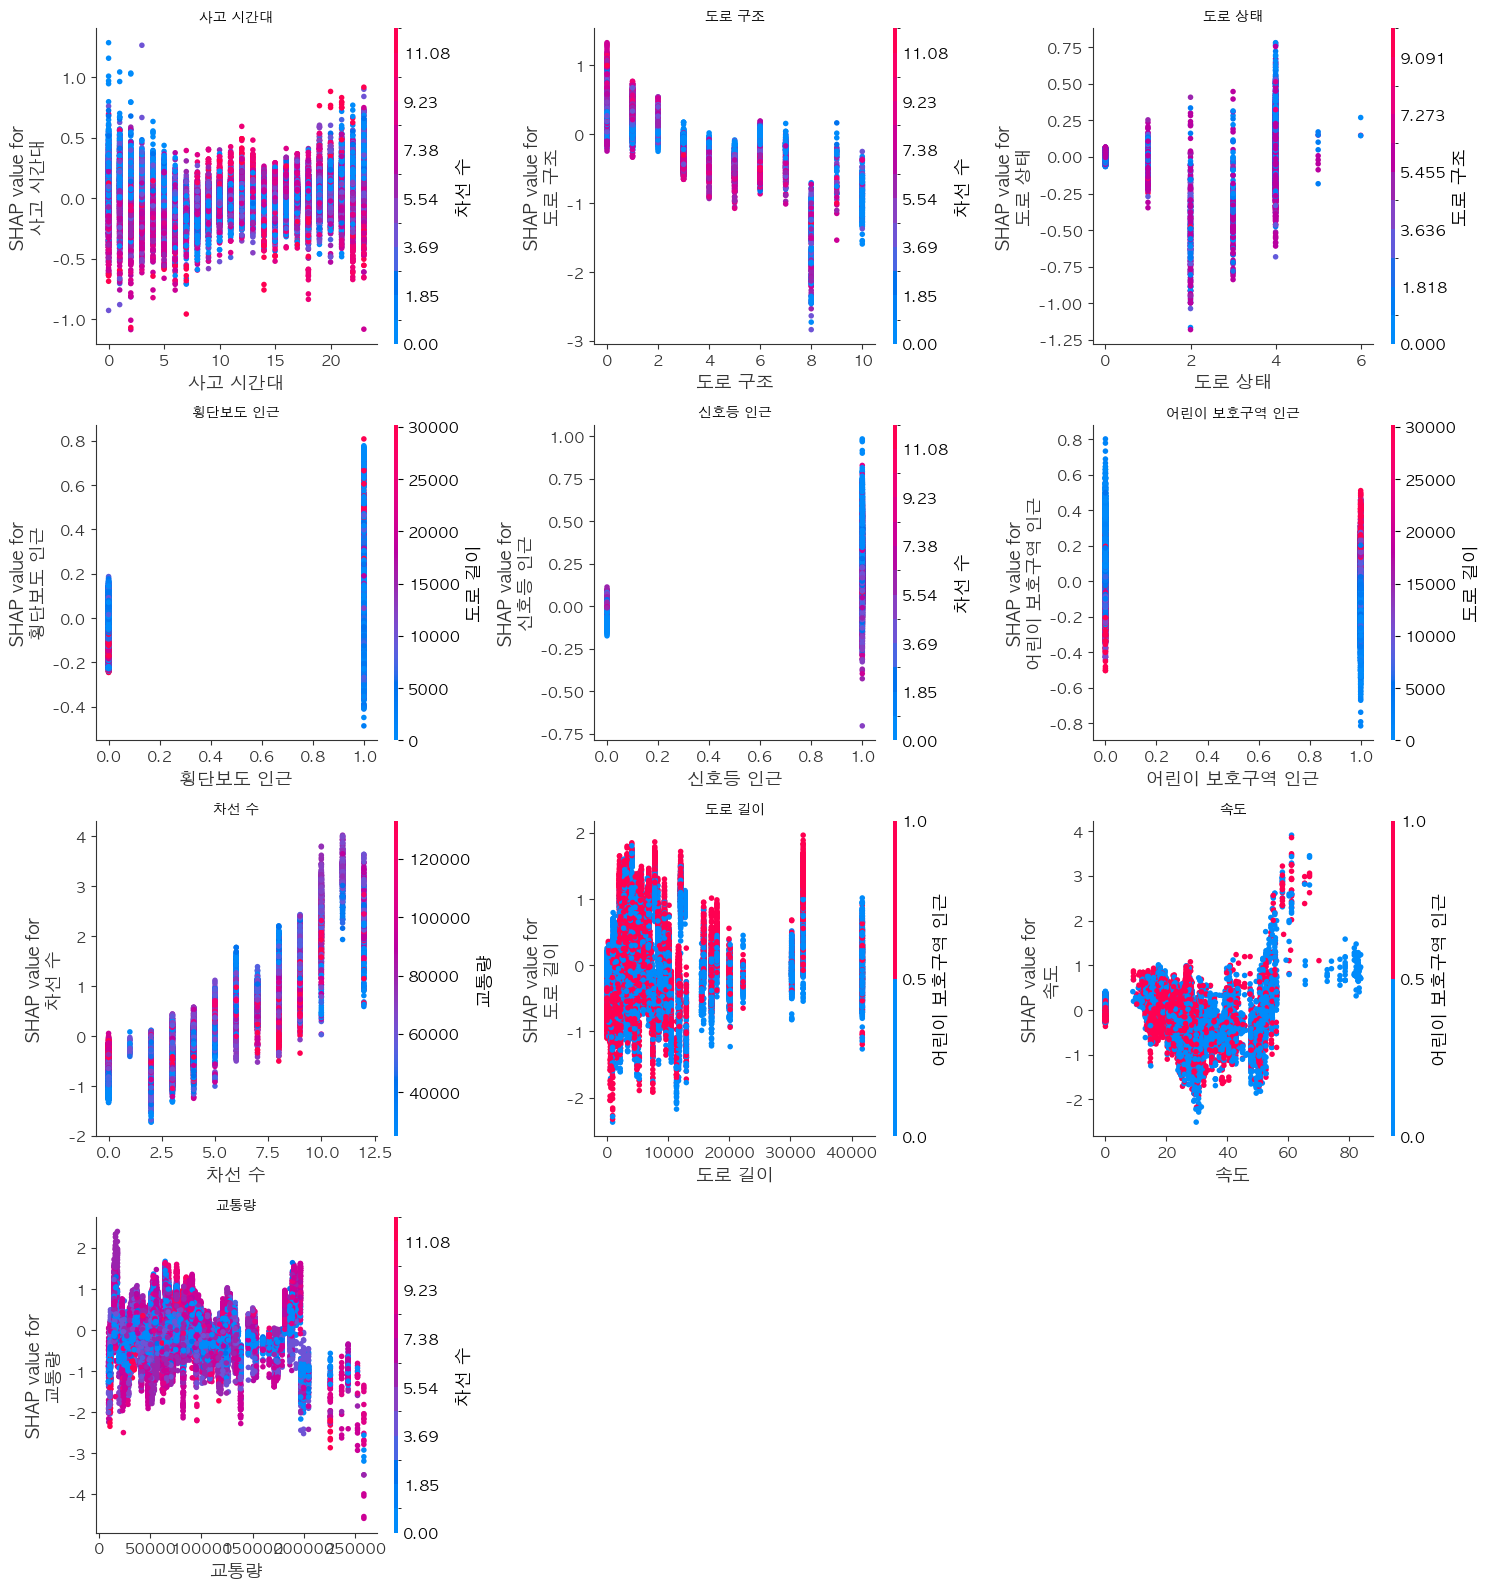

In [19]:
# # dependence plot 예시
# shap.dependence_plot(selected_features[0], shap_values, X)

# 설정: 가로로 3개씩
cols = 3
features = X.columns.tolist()
rows = math.ceil(len(features) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  # 2차원 배열을 1차원으로 변환

for i, feat in enumerate(features):
    shap.dependence_plot(
        feat,
        shap_values,
        X,
        # interaction_index=None,  # 색상 변수 생략 or interaction 지정 가능
        ax=axes[i],
        show=False
    )
    axes[i].set_title(f"{feat}", fontsize=10)

# 나머지 빈 칸은 숨기기
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 사고 시간대 + 나머지요소 상관관계 분석

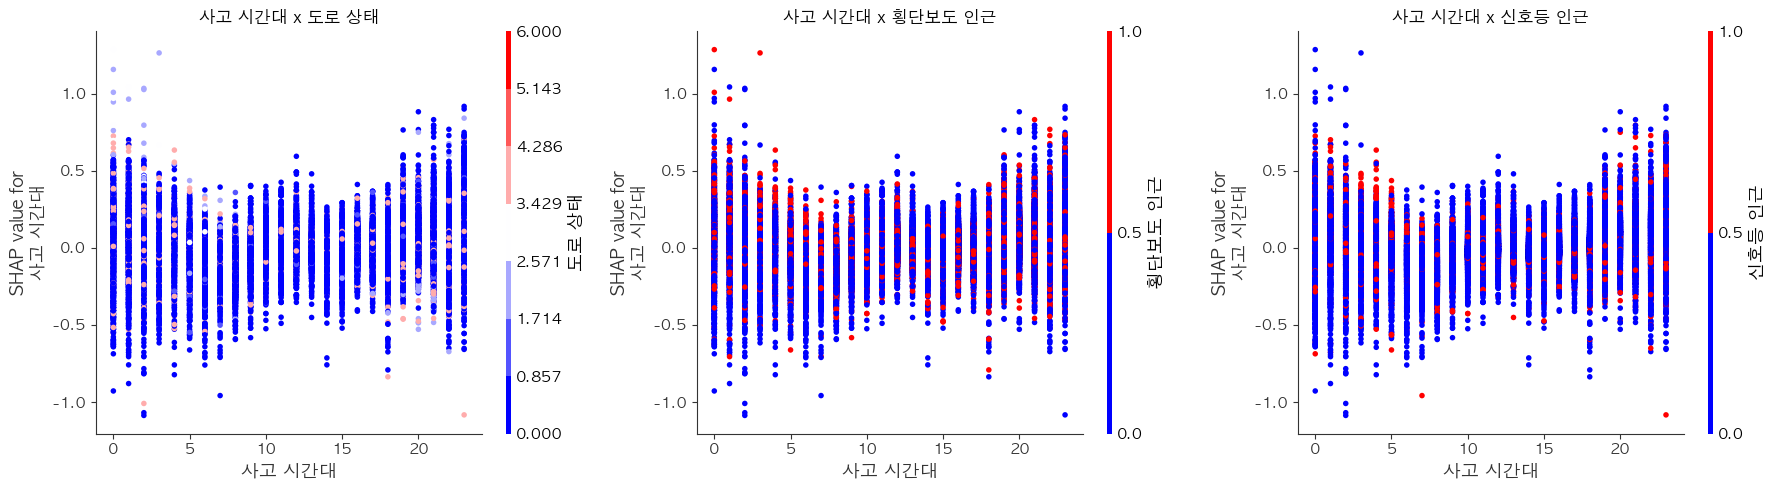

In [20]:
# 기본 설정
target_feature = "사고 시간대"
color_candidates = [ "도로 상태", "횡단보도 인근", "신호등 인근"]  # 컬러로 바꿔가며 비교할 변수들
cols = 3
rows = math.ceil(len(color_candidates) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()

for i, interaction_feat in enumerate(color_candidates):
    shap.dependence_plot(
        ind=target_feature,
        shap_values=shap_values,
        features=X,
        interaction_index=interaction_feat,
        ax=axes[i],
        show=False,
        cmap=plt.get_cmap("bwr")  # 컬러 대비 강한 colormap 사용
    )
    axes[i].set_title(f"{target_feature} x {interaction_feat}", fontsize=12)

# 남은 subplot 빈칸 제거;'?
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

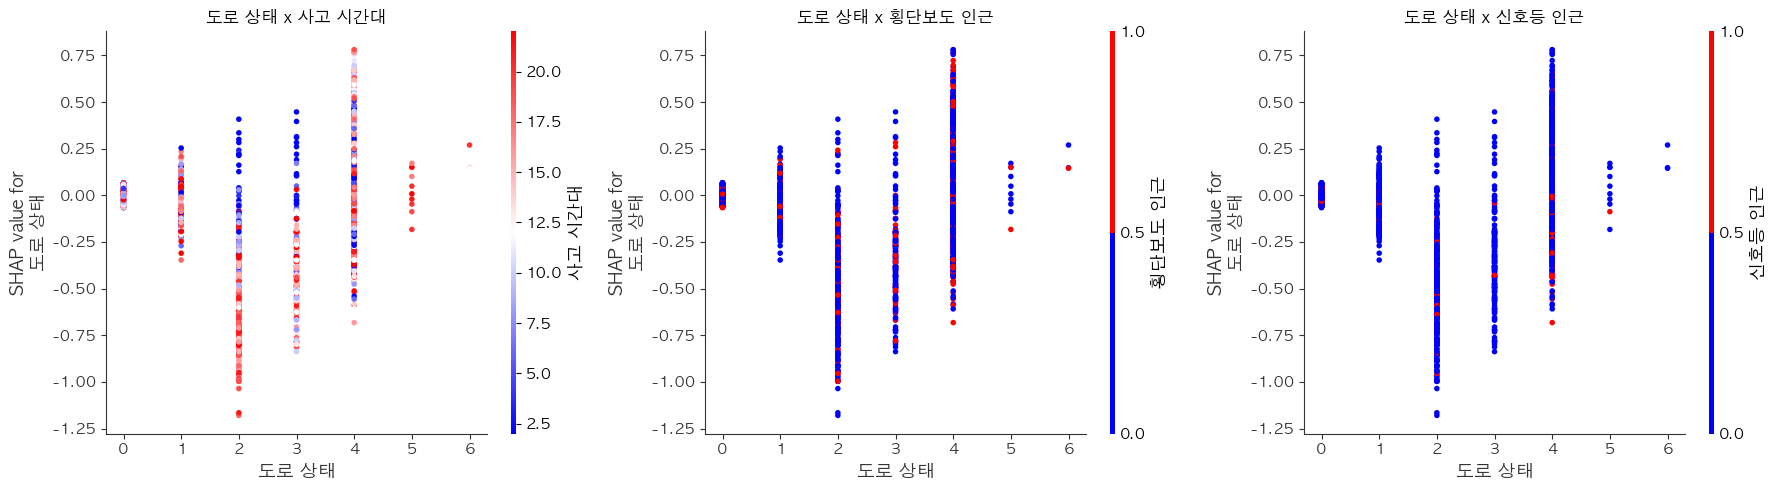

In [21]:
# 기본 설정
target_feature = "도로 상태"
color_candidates = [ "사고 시간대", "횡단보도 인근", "신호등 인근"]  # 컬러로 바꿔가며 비교할 변수들
cols = 3
rows = math.ceil(len(color_candidates) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()

for i, interaction_feat in enumerate(color_candidates):
    shap.dependence_plot(
        ind=target_feature,
        shap_values=shap_values,
        features=X,
        interaction_index=interaction_feat,
        ax=axes[i],
        show=False,
        cmap=plt.get_cmap("bwr")  # 컬러 대비 강한 colormap 사용
    )
    axes[i].set_title(f"{target_feature} x {interaction_feat}", fontsize=12)

# 남은 subplot 빈칸 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

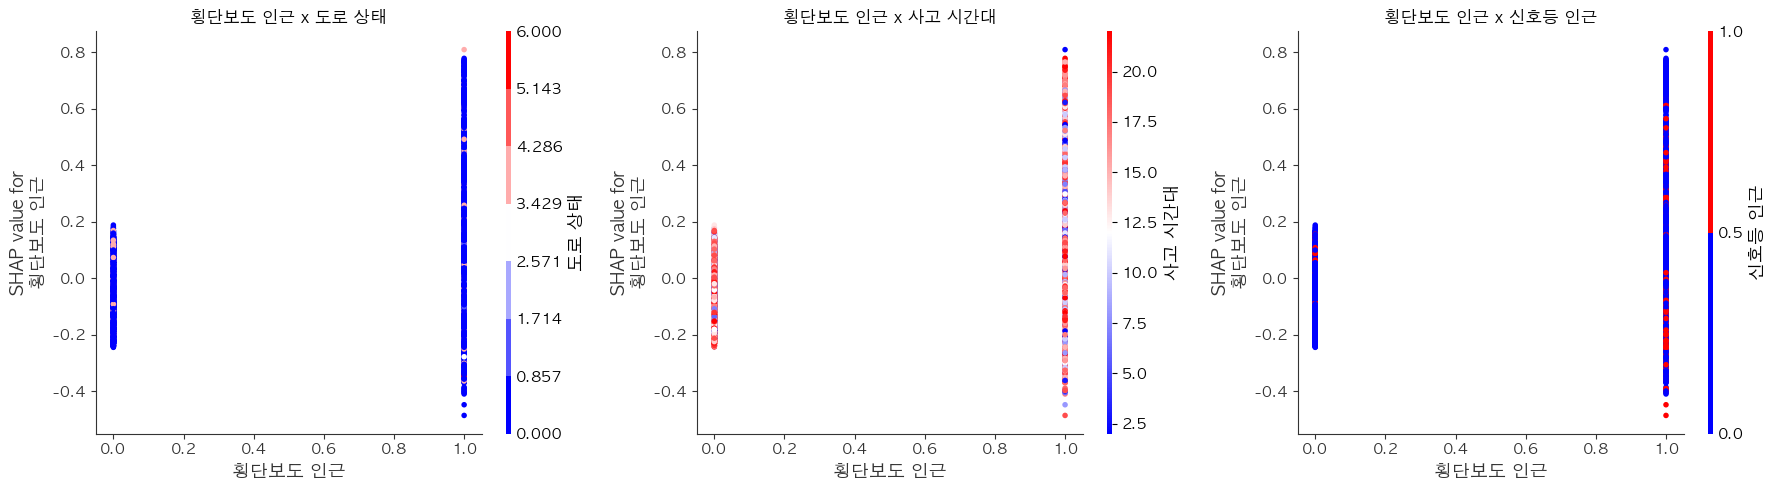

In [22]:
# 기본 설정
target_feature = "횡단보도 인근"
color_candidates = [ "도로 상태", "사고 시간대", "신호등 인근"]  # 컬러로 바꿔가며 비교할 변수들

cols = 3
rows = math.ceil(len(color_candidates) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()

for i, interaction_feat in enumerate(color_candidates):
    shap.dependence_plot(
        ind=target_feature,
        shap_values=shap_values,
        features=X,
        interaction_index=interaction_feat,
        ax=axes[i],
        show=False,
        cmap=plt.get_cmap("bwr")  # 컬러 대비 강한 colormap 사용
    )
    axes[i].set_title(f"{target_feature} x {interaction_feat}", fontsize=12)

# 남은 subplot 빈칸 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

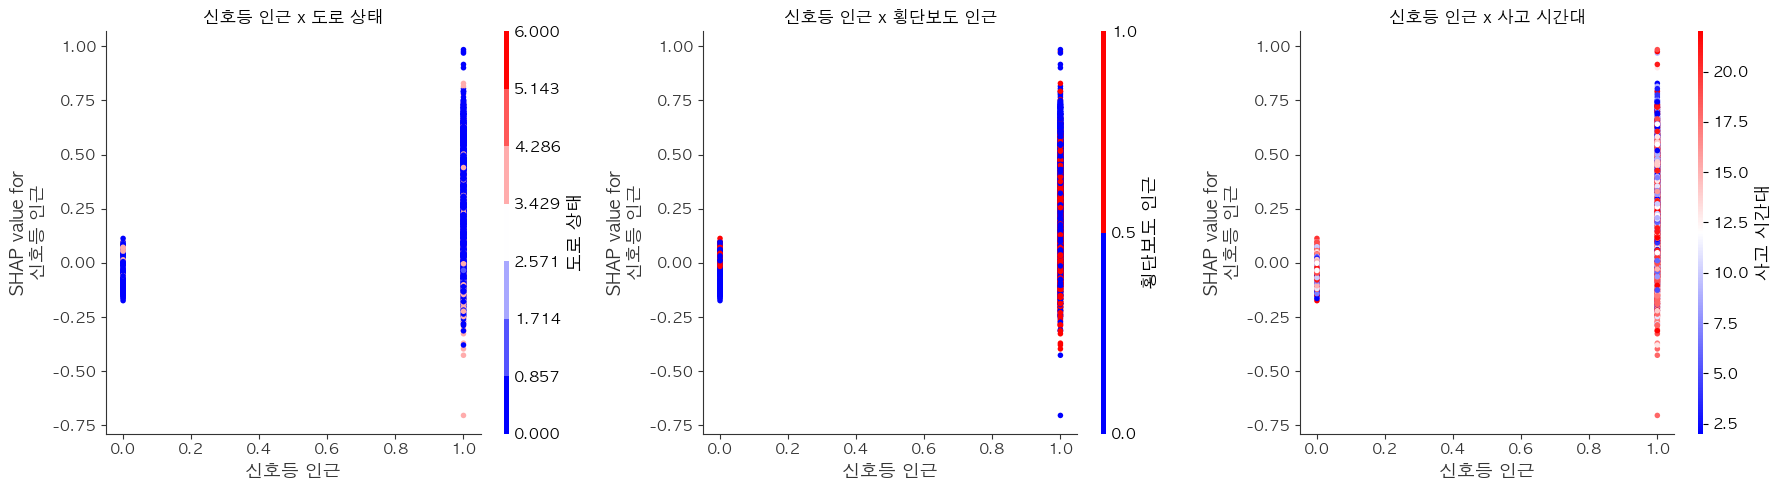

In [23]:
# 기본 설정
target_feature = "신호등 인근"
color_candidates = [ "도로 상태", "횡단보도 인근", "사고 시간대"]  # 컬러로 바꿔가며 비교할 변수들

cols = 3
rows = math.ceil(len(color_candidates) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()

for i, interaction_feat in enumerate(color_candidates):
    shap.dependence_plot(
        ind=target_feature,
        shap_values=shap_values,
        features=X,
        interaction_index=interaction_feat,
        ax=axes[i],
        show=False,
        cmap=plt.get_cmap("bwr")  # 컬러 대비 강한 colormap 사용
    )
    axes[i].set_title(f"{target_feature} x {interaction_feat}", fontsize=12)

# 남은 subplot 빈칸 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()